In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# %matplotlib qt
%matplotlib inline


In [2]:
def get_pixel_density_histogram(img):
    bottom_area = img[img.shape[0] // 3:, :]
    return np.sum(bottom_area, axis=0)


def get_normalized_pivots(img, left_pivot, right_pivot):
    midpoint = np.int(img.shape[0] / 2)
    space_between = np.int(img.shape[0] - (img.shape[0] / 2.7))
    margin = np.int(img.shape[0] - (img.shape[0] / 1))
    most_dense = max(left_pivot, right_pivot)
    if (most_dense > midpoint) & (left_pivot < right_pivot - margin):
        left_pivot = right_pivot - space_between
    if (most_dense < midpoint) & (right_pivot > left_pivot + margin):
        right_pivot = left_pivot + space_between
    return left_pivot, right_pivot


def get_path(rectangle_stack, min_pixel_density):
    total = len(rectangle_stack)
    max_empty_interval = total / 4
    count = 0

    for rectangle in rectangle_stack:
        if count > max_empty_interval:
            return None
        if len(rectangle) > min_pixel_density:
            count = 0
        else:
            count = count + 1

    path = np.concatenate(rectangle_stack)

    if len(path) < (min_pixel_density * total) / 3:
        return None

    return path


def get_lane(img, rectangle_count, rectangle_width, rectangle_visible, min_pixel_density):
    nonzero = img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    out_img = np.dstack((img, img, img)) * 255

    pixel_density_histogram = get_pixel_density_histogram(img)
    midpoint = np.int(pixel_density_histogram.shape[0] / 2)
    left_pivot, right_pivot = \
        get_normalized_pivots(img, np.argmax(pixel_density_histogram[:midpoint]),
                              np.argmax(pixel_density_histogram[midpoint:]) + midpoint)

    rect_height = np.int(img.shape[0] / rectangle_count)

    left_stack = []
    right_stack = []

    # Step through the rectangles one by one
    for rectangle in range(rectangle_count):

        # Identify rectangle boundaries in x and y (and right and left)
        rect_y_bottom = img.shape[0] - (rectangle + 1) * rect_height
        rect_y_top = img.shape[0] - rectangle * rect_height
        rect_x_left_bottom = left_pivot - rectangle_width
        rect_x_left_top = left_pivot + rectangle_width
        rect_x_right_bottom = right_pivot - rectangle_width
        rect_x_right_top = right_pivot + rectangle_width

        # Identify the nonzero pixels in x and y within the rectangle
        left_rect_area = ((nonzero_y >= rect_y_bottom) &
                          (nonzero_y < rect_y_top) &
                          (nonzero_x >= rect_x_left_bottom) &
                          (nonzero_x < rect_x_left_top)).nonzero()[0]

        right_rect_area = ((nonzero_y >= rect_y_bottom) &
                           (nonzero_y < rect_y_top) &
                           (nonzero_x >= rect_x_right_bottom) &
                           (nonzero_x < rect_x_right_top)).nonzero()[0]

        # If you found > min_pixel_density, recenter next rectangle on their mean position
        if len(left_rect_area) > min_pixel_density:
            left_pivot, right_pivot = get_normalized_pivots(
                img, np.int(np.mean(nonzero_x[left_rect_area])), right_pivot)
        if len(right_rect_area) > min_pixel_density:
            left_pivot, right_pivot = get_normalized_pivots(
                img, left_pivot, np.int(np.mean(nonzero_x[right_rect_area])))

        # append indexes skiping initial iteractions
        if rectangle >= rectangle_count / 10:
            left_stack.append(left_rect_area)
            right_stack.append(right_rect_area)

        # Draw the windows on the visualization image
        if rectangle_visible:
            cv2.rectangle(out_img, (rect_x_left_bottom, rect_y_bottom), (rect_x_left_top, rect_y_top), (0, 255, 0), 2)
            cv2.rectangle(out_img, (rect_x_right_bottom, rect_y_bottom), (rect_x_right_top, rect_y_top), (0, 255, 0), 2)

    # Flatten the rectangle stack
    left_path = get_path(left_stack, min_pixel_density)
    right_path = get_path(right_stack, min_pixel_density)
    return left_path, right_path, out_img


def pixel_density_curve_fit(img,
                            rectangle_count=20, rectangle_width=80, rectangle_visible=False,
                            lane_width=75,
                            min_pixel_density=100):
    nonzero = img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # get paths and output image
    left_path, right_path, out_img = \
        get_lane(img, rectangle_count, rectangle_width, rectangle_visible, min_pixel_density)

    # Generate x and y values for plotting
    plot_y = np.linspace(0, out_img.shape[0] - 1, out_img.shape[0])
    lane_img = np.zeros_like(out_img)
    left_fit = None
    right_fit = None
    if left_path is not None:
        left_x = nonzero_x[left_path]
        left_y = nonzero_y[left_path]
        out_img[nonzero_y[left_path], nonzero_x[left_path]] = [255, 255, 0]
        try:
            left_fit = np.polyfit(left_y, left_x, 2)
            left_fit_x = left_fit[0] * plot_y ** 2 + left_fit[1] * plot_y + left_fit[2]
            left_lane_rect_a = np.array([np.transpose(np.vstack([left_fit_x - lane_width, plot_y]))])
            left_lane_rect_b = np.array([np.flipud(np.transpose(np.vstack([left_fit_x + lane_width, plot_y])))])
            left_lane_pts = np.hstack((left_lane_rect_a, left_lane_rect_b))
            cv2.fillPoly(lane_img, np.int_([left_lane_pts]), (255, 0, 0))
        except:
            left_fit = None

    if right_path is not None:
        right_x = nonzero_x[right_path]
        right_y = nonzero_y[right_path]
        out_img[nonzero_y[right_path], nonzero_x[right_path]] = [255, 255, 0]
        try:
            right_fit = np.polyfit(right_y, right_x, 2)
            right_fit_x = right_fit[0] * plot_y ** 2 + right_fit[1] * plot_y + right_fit[2]
            right_lane_rect_a = np.array([np.transpose(np.vstack([right_fit_x - lane_width, plot_y]))])
            right_lane_rect_b = np.array([np.flipud(np.transpose(np.vstack([right_fit_x + lane_width, plot_y])))])
            right_lane_pts = np.hstack((right_lane_rect_a, right_lane_rect_b))
            cv2.fillPoly(lane_img, np.int_([right_lane_pts]), (0, 0, 255))
        except:
            right_fit = None

    out_img = cv2.addWeighted(out_img, 1, lane_img, 0.7, 0)
    return left_fit, right_fit, out_img


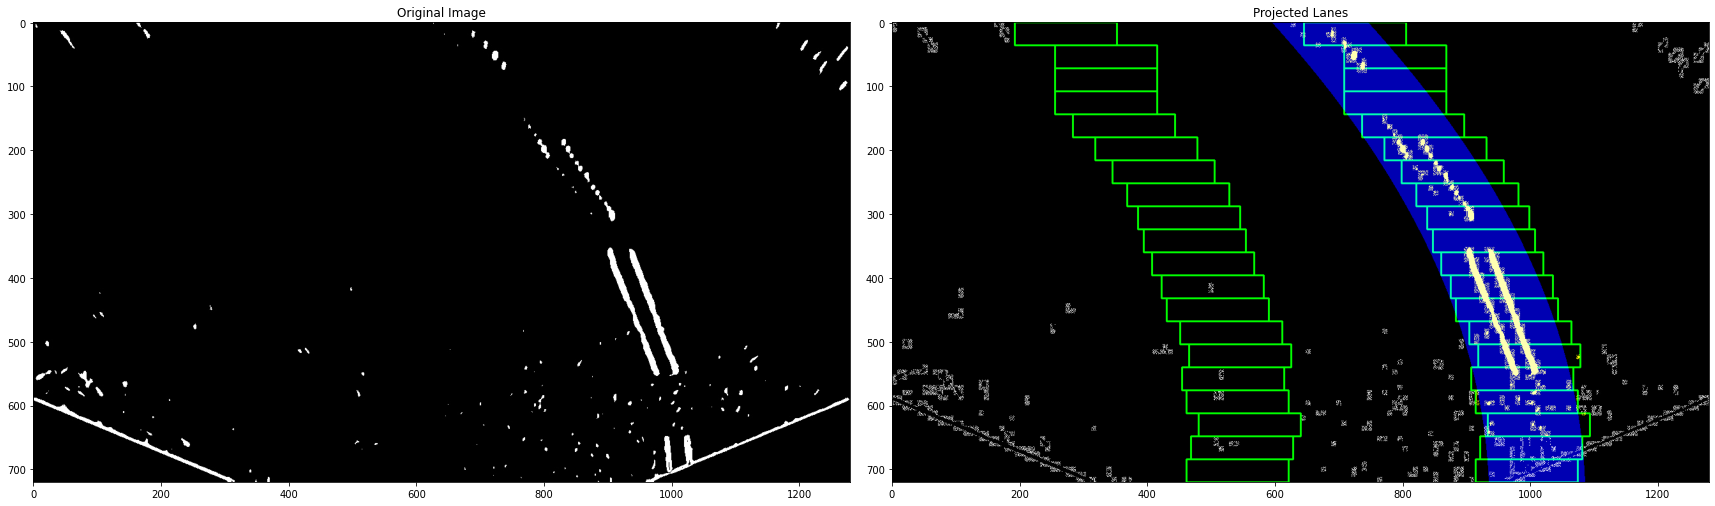

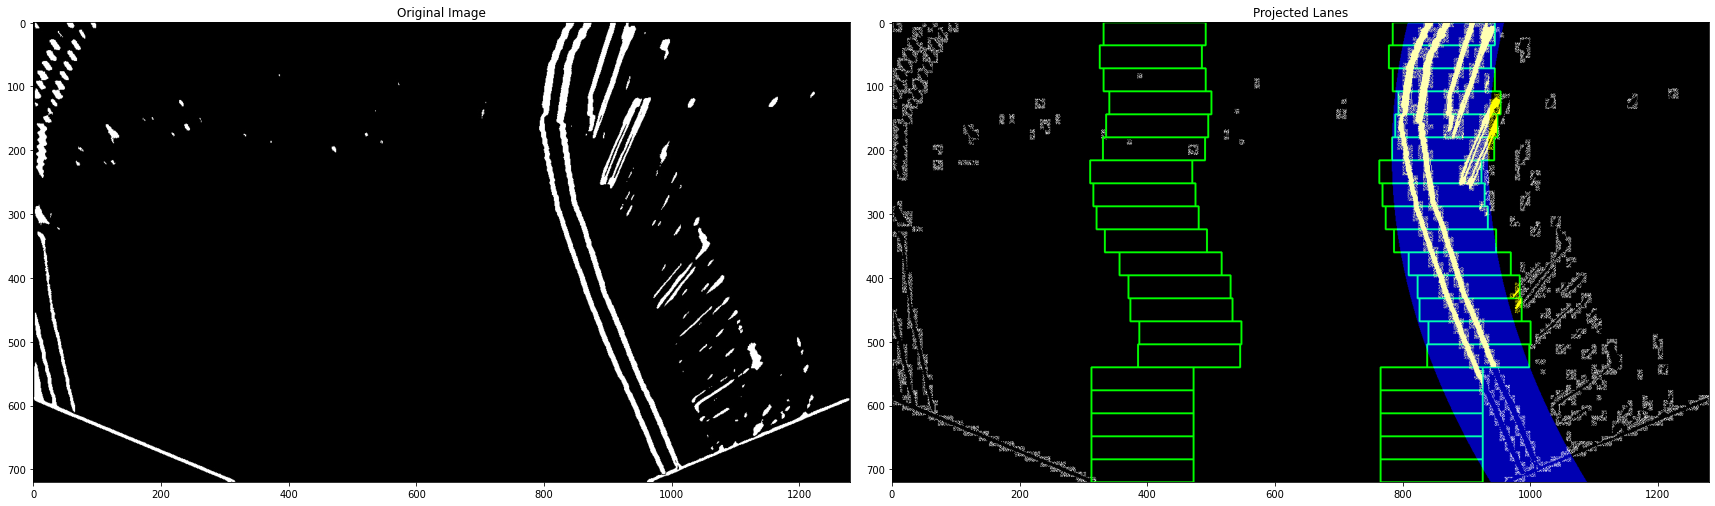

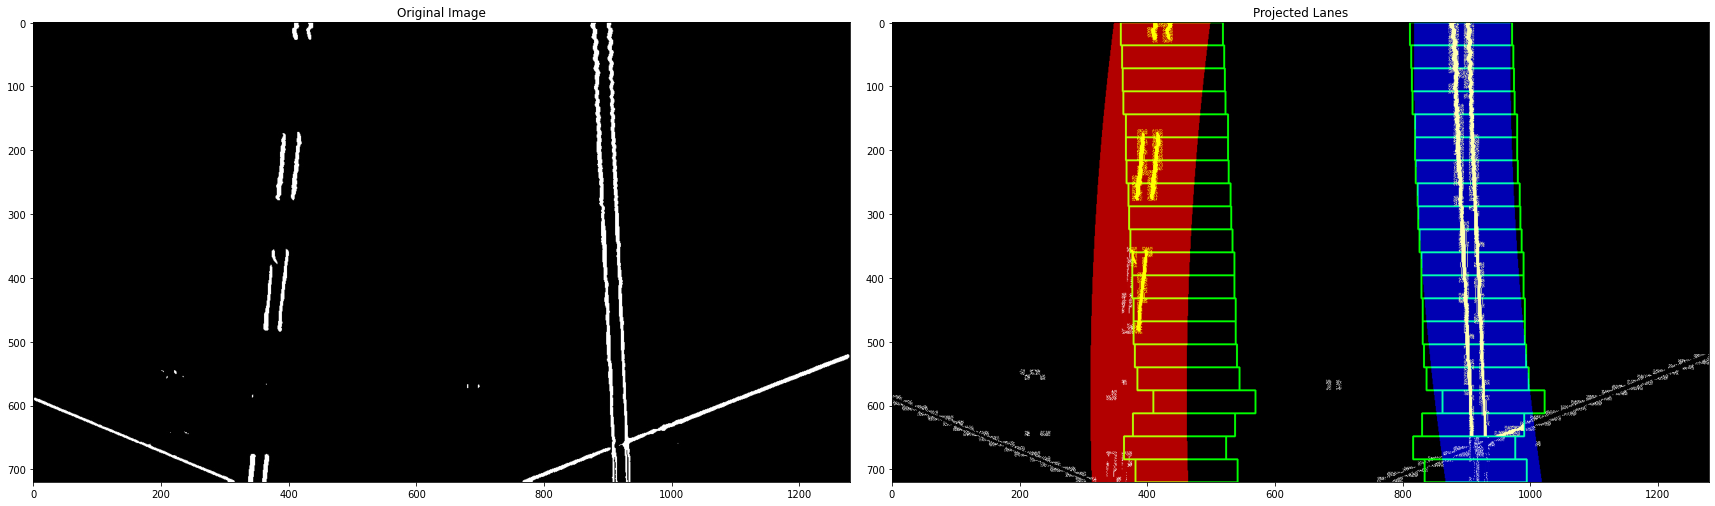

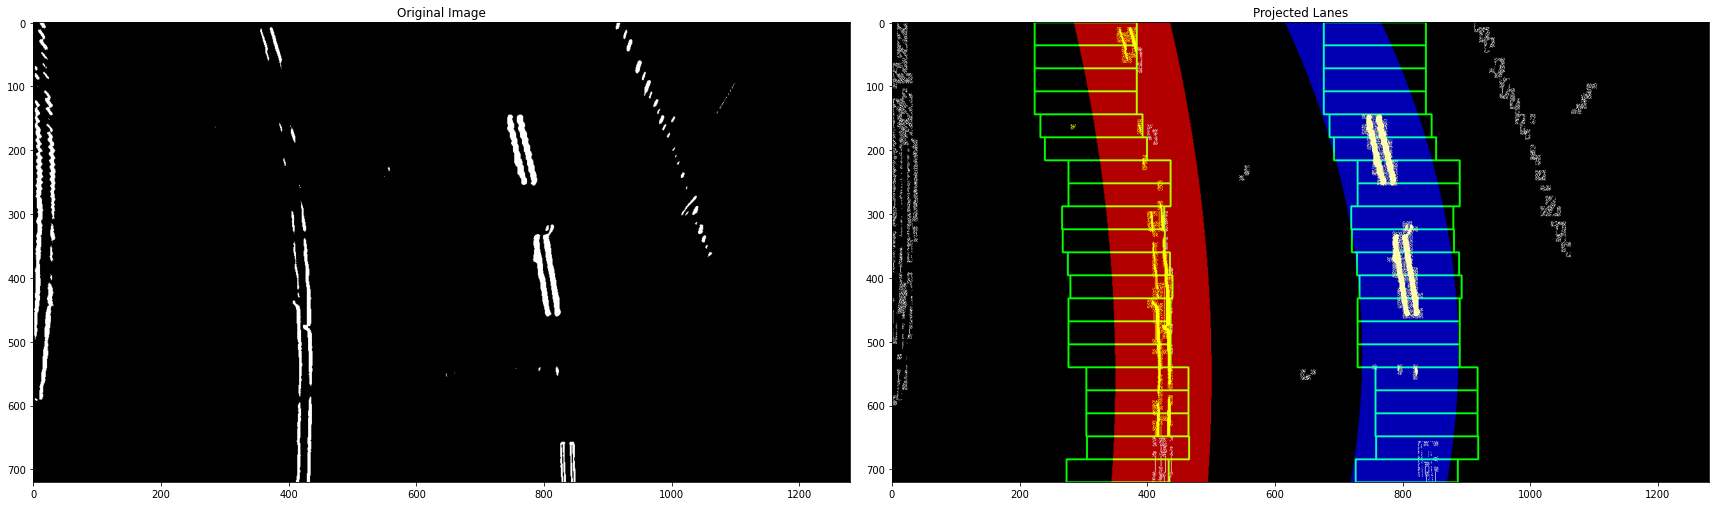

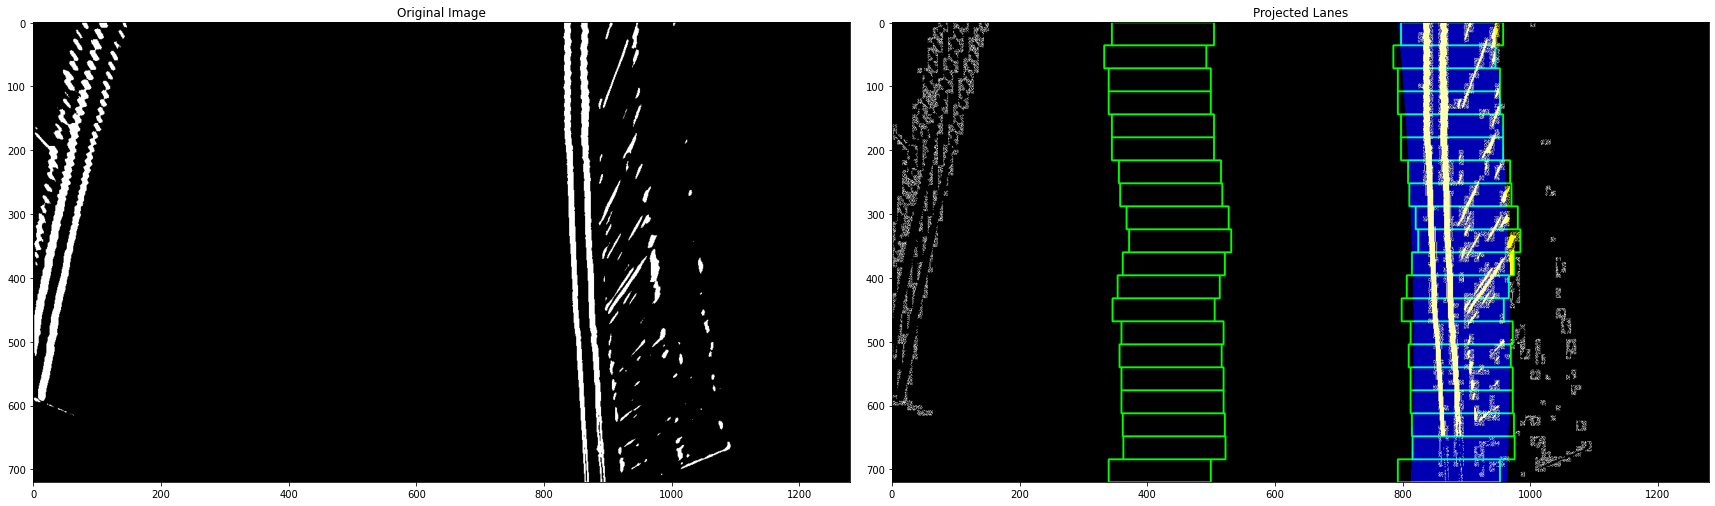

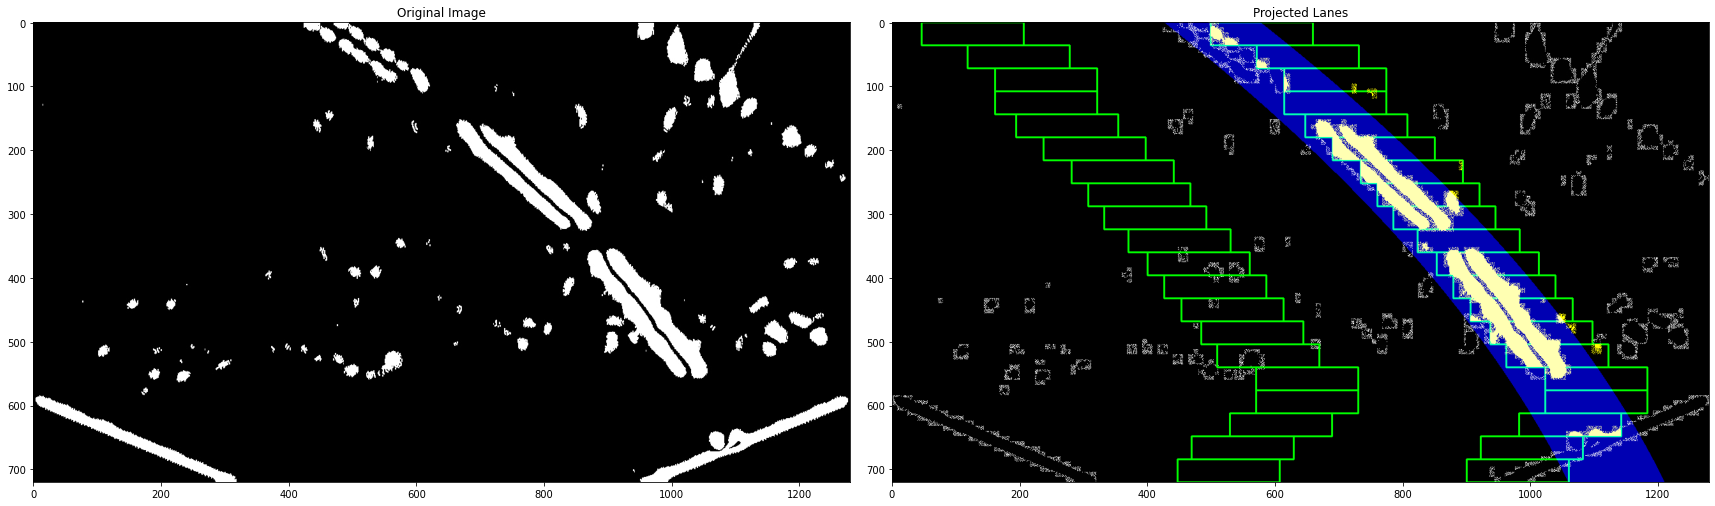

In [3]:
### get the test images from the test_images folder
images = glob.glob('../test*/lane_detection_image_edge.jpg')
        

### Loop through each image and send it to the pipeline
for fname in images:
    
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    left_fit, right_fit, out_img = pixel_density_curve_fit(img, rectangle_visible=True)

    ### Plot the original image, the binary warped image, and the visualization from the fitter
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    ax2.imshow(out_img)
    ax2.set_title('Projected Lanes')
    
    ### Improvement: https://www.intmath.com/applications-differentiation/8-radius-curvature.php